In [14]:
%pylab inline
import xcml
import siestah2o as h2o
import pickle
from mbpol_calculator import MbpolCalculator, reconnect_monomers
from ase import Atoms
import siesta_utils.grid as siesta
from ase.io import iread
import config as c

Populating the interactive namespace from numpy and matplotlib


In [102]:
basis = 'sz'
features = 'descr'
every = 1
which = -1

In [103]:
#Load relevant models 

e_model = False
f_model = False
fd_model = False
try:
    krr_O = pickle.load(open(c.model_basepath + c.par[features]['krr_o'][basis], 'rb'))
    krr_H = pickle.load(open(c.model_basepath + c.par[features]['krr_h'][basis], 'rb'))
#     krr_O = pickle.load(open('/gpfs/home/smdick/exchange_ml/models/final/krr_Oxygen_descr_seawulf', 'rb'))
#     krr_H = pickle.load(open('/gpfs/home/smdick/exchange_ml/models/final/krr_Hydrogen_descr_seawulf', 'rb'))
    f_model = True
except KeyError:
    print('No force model found')    
try:
    krr_O_dx = pickle.load(open(c.model_basepath + c.par[features]['krr_o_dx'][basis], 'rb'))
    krr_H_dx = pickle.load(open(c.model_basepath + c.par[features]['krr_h_dx'][basis], 'rb'))
    fd_model = True
except KeyError:
    print('No finite diff. model found')
try:
    nn = xcml.load_network(c.model_basepath + c.par[features]['nn'][basis])
    e_model = True
except KeyError:
    print('No energy model found')
    
# Load data 

if features == 'descr':
    n_o_orb = 18
    n_h_orb = 8
else:
    n_o_orb = c.par[features]['n_o_orb'][basis]
    n_h_orb = c.par[features]['n_h_orb'][basis]
n_orb = n_o_orb + 2*n_h_orb

No finite diff. model found
INFO:tensorflow:Restoring parameters from /gpfs/home/smdick/exchange_ml/models/final/nn_descriptors_sztoqz/model.ckpt


In [104]:
# M_sz = np.genfromtxt('/gpfs/home/smdick/exchange_ml/data/synced/128/{}/M.dat'.format(basis), delimiter = ',').reshape(-1,128,n_orb)
M_sz = np.genfromtxt('/gpfs/home/smdick/exchange_ml/data/synced/128/{}/descriptors_coeff.dat'.format(basis), delimiter = ',').reshape(-1,128,n_orb)[which]

In [105]:
coords = np.genfromtxt('/gpfs/home/smdick/exchange_ml/data/synced/128/{}/coords.gauss'.format(basis), delimiter = ',').reshape(-1,128,3,3)[which]
forces_sz = np.genfromtxt('/gpfs/home/smdick/exchange_ml/data/synced/128/{}/forces.dat'.format(basis), delimiter = ',').reshape(-1,128,3,3)[which]
forces_dz = np.genfromtxt('/gpfs/home/smdick/exchange_ml/data/synced/128/dzp/forces.dat', delimiter = ',').reshape(-1,128,3,3)[which]

siesta.unitcell = np.zeros([3,3])
siesta.unitcell[0,0] = 15.646*xcml.AtoBohr

In [106]:
symmetry = np.genfromtxt('../symmetry.dat')

In [139]:
corr = xcml.use_force_model(M_sz.reshape(-1,n_orb), krr_O, krr_H, n_o_orb, n_h_orb, True,
                            xcml.fold_back_coords(coords.reshape(-1,3,3),siesta), sym= symmetry, which_sym=[2])

In [140]:
forces_corrected = forces_sz - corr.reshape(128,3,3)

2.978607803542183
0.23096644882362166


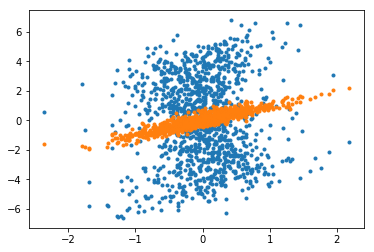

In [141]:
i = -1
a = [0,1,2]
plot(forces_dz[:,a,:].flatten(), forces_sz[:,a,:].flatten(), ls = '', marker = '.')
plot(forces_dz[:,a,:].flatten(), forces_corrected[:,a,:].flatten(), ls = '', marker = '.')
print(np.std(forces_dz[:,a,:].flatten()- forces_sz[:,a,:].flatten()))
print(np.std(forces_dz[:,a,:].flatten()- forces_corrected[:,a,:].flatten()))